In [10]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import minimize_scalar
from tqdm import tqdm
import math
import time
from functools import wraps
import matplotlib.pyplot as plt

In [22]:
def timing_decorator(func):
    """Decorator to measure function execution time."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.4f} seconds")
        return result
    return wrapper

@timing_decorator
def generate_spiked_matrix_tensor_optimized(N, Delta2, Delta_p, p=3, seed=None):
    """
    Optimized version of generate_spiked_matrix_tensor.
    Generate a random spike x_star (||x_star|| = sqrt(N)),
    and noisy observations Y (matrix) and T (3-order tensor).
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Start timing sections
    start_total = time.perf_counter()
    
    # 1) Generate Normalized True spike x_star
    start_spike = time.perf_counter()
    x_star = np.random.randn(N)
    x_star *= np.sqrt(N) / np.linalg.norm(x_star)
    print(f"  Spike generation: {time.perf_counter() - start_spike:.4f}s")
    
    # 2) Initialize tensor
    start_init = time.perf_counter()
    T = np.zeros((N, N, N))
    print(f"  Tensor initialization: {time.perf_counter() - start_init:.4f}s")
    
    # 3) Compute scaling factor once
    scale = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2.0))
    
    # 4) Fill tensor with optimizations
    start_fill = time.perf_counter()
    
    # Pre-generate all noise values at once (more efficient)
    n_combinations = N * (N - 1) * (N - 2) // 6
    noise_values = np.random.randn(n_combinations) * np.sqrt(Delta_p)
    
    # Vectorized approach for better performance
    idx = 0
    for i in range(N):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                # Compute signal once
                sig = scale * x_star[i] * x_star[j] * x_star[k]
                val = sig + noise_values[idx]
                idx += 1
                
                # Assign to all 6 permutations
                T[i, j, k] = T[i, k, j] = T[j, i, k] = val
                T[j, k, i] = T[k, i, j] = T[k, j, i] = val
    
    print(f"  Tensor filling: {time.perf_counter() - start_fill:.4f}s")
    print(f"  Total time: {time.perf_counter() - start_total:.4f}s")
    
    return x_star, T

def generate_spiked_matrix_tensor_ultra_optimized(N, Delta2, Delta_p, p=3, seed=None):
    """
    Ultra-optimized version using advanced NumPy vectorization.
    Best for large N values.
    """
    if seed is not None:
        np.random.seed(seed)
    
    start_total = time.perf_counter()
    
    # 1) Generate Normalized True spike x_star
    x_star = np.random.randn(N)
    x_star *= np.sqrt(N) / np.linalg.norm(x_star)
    
    # 2) Pre-compute all unique triplet indices
    triplets = np.array(list(combinations(range(N), 3)))
    n_triplets = len(triplets)
    
    # 3) Vectorized computation of signals
    scale = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2.0))
    signals = scale * x_star[triplets[:, 0]] * x_star[triplets[:, 1]] * x_star[triplets[:, 2]]
    
    # 4) Generate noise for all triplets at once
    noise = np.random.randn(n_triplets) * np.sqrt(Delta_p)
    values = signals + noise
    
    # 5) Fill tensor using advanced indexing
    T = np.zeros((N, N, N))
    for idx, (i, j, k) in enumerate(triplets):
        val = values[idx]
        T[i, j, k] = T[i, k, j] = T[j, i, k] = val
        T[j, k, i] = T[k, i, j] = T[k, j, i] = val
    
    print(f"Ultra-optimized total time: {time.perf_counter() - start_total:.4f}s")
    
    return x_star, T

# Benchmark function to compare implementations
def benchmark_implementations(N_values=[50, 100, 200], Delta2=1.0, Delta_p=1.0):
    """
    Benchmark different implementations for various N values.
    """
    print("Benchmarking tensor generation implementations...\n")
    
    for N in N_values:
        print(f"\n{'='*50}")
        print(f"N = {N} (Total unique triplets: {N*(N-1)*(N-2)//6})")
        print(f"{'='*50}")
        
        # Test optimized version
        print("\nOptimized version:")
        x1, T1 = generate_spiked_matrix_tensor_optimized(N, Delta2, Delta_p, seed=42)
        
        # Test ultra-optimized version
        print("\nUltra-optimized version:")
        x2, T2 = generate_spiked_matrix_tensor_ultra_optimized(N, Delta2, Delta_p, seed=42)
        
        # Verify results are identical
        print(f"\nResults match: {np.allclose(T1, T2)}")

# Memory-efficient version for very large N
def generate_spiked_matrix_tensor_memory_efficient(N, Delta2, Delta_p, p=3, seed=None, chunk_size=1000):
    """
    Memory-efficient version that processes triplets in chunks.
    Best for very large N where memory is a constraint.
    """
    if seed is not None:
        np.random.seed(seed)
    
    start_total = time.perf_counter()
    
    # Generate spike
    x_star = np.random.randn(N)
    x_star *= np.sqrt(N) / np.linalg.norm(x_star)
    
    # Initialize tensor
    T = np.zeros((N, N, N))
    scale = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2.0))
    
    # Process in chunks to save memory
    processed = 0
    for i in range(N):
        for j in range(i + 1, N):
            # Collect k indices for this chunk
            k_indices = list(range(j + 1, N))
            
            if k_indices:
                # Vectorized computation for this chunk
                k_arr = np.array(k_indices)
                signals = scale * x_star[i] * x_star[j] * x_star[k_arr]
                noise = np.random.randn(len(k_indices)) * np.sqrt(Delta_p)
                values = signals + noise
                
                # Fill tensor for this chunk
                for idx, k in enumerate(k_indices):
                    val = values[idx]
                    T[i, j, k] = T[i, k, j] = T[j, i, k] = val
                    T[j, k, i] = T[k, i, j] = T[k, j, i] = val
                
                processed += len(k_indices)
    
    print(f"Memory-efficient version completed in {time.perf_counter() - start_total:.4f}s")
    print(f"Processed {processed} unique triplets")
    
    return x_star, T

In [27]:
# Quick test
N = 100
print(f"Testing with N={N}")
x_star, T = generate_spiked_matrix_tensor_optimized(N, Delta2=1.0, Delta_p=1.0, seed=42)
print(f"\nSpike norm: {np.linalg.norm(x_star):.4f} (should be ~{np.sqrt(N):.4f})")
print(f"Tensor shape: {T.shape}")
print(f"Tensor is symmetric: {np.allclose(T, T.transpose(1, 0, 2))}")

# Run benchmark
print("\n" + "="*60)
benchmark_implementations([50, 100, 150, 500, 750])

Testing with N=100
  Spike generation: 0.0005s
  Tensor initialization: 0.0019s
  Tensor filling: 0.1331s
  Total time: 0.1357s
generate_spiked_matrix_tensor_optimized took 0.1359 seconds

Spike norm: 10.0000 (should be ~10.0000)
Tensor shape: (100, 100, 100)
Tensor is symmetric: True

Benchmarking tensor generation implementations...


N = 50 (Total unique triplets: 19600)

Optimized version:
  Spike generation: 0.0000s
  Tensor initialization: 0.0000s
  Tensor filling: 0.0127s
  Total time: 0.0128s
generate_spiked_matrix_tensor_optimized took 0.0128 seconds

Ultra-optimized version:
Ultra-optimized total time: 0.0229s

Results match: True

N = 100 (Total unique triplets: 161700)

Optimized version:
  Spike generation: 0.0000s
  Tensor initialization: 0.0002s
  Tensor filling: 0.1020s
  Total time: 0.1023s
generate_spiked_matrix_tensor_optimized took 0.1023 seconds

Ultra-optimized version:
Ultra-optimized total time: 0.1914s

Results match: True

N = 150 (Total unique triplets: 55130

In [29]:
[x_star, T] = generate_spiked_matrix_tensor_optimized(1000, Delta2=1.0, Delta_p=1.0, seed=42)

  Spike generation: 0.0004s
  Tensor initialization: 0.0006s


KeyboardInterrupt: 

In [ ]:
print(T(1, 0:100, 0:100))

In [4]:
import numpy as np
import math
import time
from numba import jit, prange, set_num_threads
import multiprocessing
from functools import wraps

def timing_decorator(func):
    """Decorator to measure function execution time."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.4f} seconds")
        return result
    return wrapper

@jit(nopython=True, parallel=True, fastmath=True)
def fill_tensor_numba(T, x_star, scale, sqrt_delta_p, noise_array, N):
    """
    Numba-optimized tensor filling with parallel execution.
    """
    idx = 0
    for i in prange(N):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                # Compute signal
                sig = scale * x_star[i] * x_star[j] * x_star[k]
                val = sig + noise_array[idx] * sqrt_delta_p
                idx += 1
                
                # Assign to all 6 permutations
                T[i, j, k] = val
                T[i, k, j] = val
                T[j, i, k] = val
                T[j, k, i] = val
                T[k, i, j] = val
                T[k, j, i] = val
    return T

@jit(nopython=True, fastmath=True)
def fill_tensor_block(T, x_star, scale, sqrt_delta_p, noise_array, start_i, end_i, N, noise_offset):
    """
    Fill a block of the tensor (for chunked parallel processing).
    """
    idx = noise_offset
    for i in range(start_i, end_i):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                sig = scale * x_star[i] * x_star[j] * x_star[k]
                val = sig + noise_array[idx] * sqrt_delta_p
                idx += 1
                
                T[i, j, k] = val
                T[i, k, j] = val
                T[j, i, k] = val
                T[j, k, i] = val
                T[k, i, j] = val
                T[k, j, i] = val
    return idx - noise_offset

@timing_decorator
def generate_spiked_matrix_tensor_numba(N, Delta2, Delta_p, p=3, seed=None, n_threads=None):
    """
    Numba JIT-compiled version with parallel execution.
    This should be the fastest for large N.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Set number of threads
    if n_threads is None:
        n_threads = multiprocessing.cpu_count()
    set_num_threads(n_threads)
    print(f"Using {n_threads} threads")
    
    start_total = time.perf_counter()
    
    # Generate normalized spike
    x_star = np.random.randn(N)
    x_star *= np.sqrt(N) / np.linalg.norm(x_star)
    
    # Pre-compute constants
    scale = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2.0))
    sqrt_delta_p = np.sqrt(Delta_p)
    
    # Pre-generate all noise (this is fast)
    n_triplets = N * (N - 1) * (N - 2) // 6
    noise_array = np.random.randn(n_triplets)
    
    # Initialize tensor
    T = np.zeros((N, N, N))
    
    # Call JIT-compiled function
    start_fill = time.perf_counter()
    T = fill_tensor_numba(T, x_star, scale, sqrt_delta_p, noise_array, N)
    print(f"Numba tensor filling: {time.perf_counter() - start_fill:.4f}s")
    
    print(f"Total time: {time.perf_counter() - start_total:.4f}s")
    return x_star, T

@jit(nopython=True, parallel=True, fastmath=True, cache=True)
def fill_tensor_ultra_parallel(T, x_star, scale, sqrt_delta_p, N):
    """
    Ultra-parallel version that generates noise on-the-fly to avoid memory bottleneck.
    Uses Numba's parallel random number generation.
    """
    # Each thread handles a range of i values
    for i in prange(N - 2):
        # Local random state for this thread
        local_state = np.random.randint(0, 2**31)
        np.random.seed(local_state + i)
        
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                # Generate noise on-the-fly
                noise = np.random.randn() * sqrt_delta_p
                sig = scale * x_star[i] * x_star[j] * x_star[k]
                val = sig + noise
                
                # Atomic writes to avoid race conditions
                T[i, j, k] = val
                T[i, k, j] = val
                T[j, i, k] = val
                T[j, k, i] = val
                T[k, i, j] = val
                T[k, j, i] = val
    return T

@timing_decorator
def generate_spiked_matrix_tensor_ultra_parallel(N, Delta2, Delta_p, p=3, seed=None, n_threads=None):
    """
    Ultra-parallel version that avoids memory bottlenecks.
    """
    if seed is not None:
        np.random.seed(seed)
    
    if n_threads is None:
        n_threads = multiprocessing.cpu_count()
    set_num_threads(n_threads)
    print(f"Using {n_threads} threads (ultra-parallel)")
    
    start_total = time.perf_counter()
    
    # Generate normalized spike
    x_star = np.random.randn(N).astype(np.float64)
    x_star *= np.sqrt(N) / np.linalg.norm(x_star)
    
    # Pre-compute constants
    scale = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2.0))
    sqrt_delta_p = np.sqrt(Delta_p)
    
    # Initialize tensor
    T = np.zeros((N, N, N), dtype=np.float64)
    
    # Call ultra-parallel JIT-compiled function
    start_fill = time.perf_counter()
    T = fill_tensor_ultra_parallel(T, x_star, scale, sqrt_delta_p, N)
    print(f"Ultra-parallel tensor filling: {time.perf_counter() - start_fill:.4f}s")
    
    print(f"Total time: {time.perf_counter() - start_total:.4f}s")
    return x_star, T

# Compile functions ahead of time
print("Compiling Numba functions (this may take a moment on first run)...")
dummy_T = np.zeros((10, 10, 10))
dummy_x = np.ones(10)
dummy_noise = np.ones(120)
_ = fill_tensor_numba(dummy_T, dummy_x, 1.0, 1.0, dummy_noise, 10)
_ = fill_tensor_ultra_parallel(dummy_T, dummy_x, 1.0, 1.0, 10)
print("Compilation complete!\n")

# Note: Multiprocessing implementation removed due to compatibility issues
# with Numba in certain environments. Use the Numba parallel versions instead.

# Benchmark all implementations
def benchmark_fast_implementations(N_values=[100, 250, 500], Delta2=1.0, Delta_p=1.0, p=3):
    """
    Benchmark the fastest implementations.
    """
    print("Benchmarking fastest tensor generation implementations...\n")
    
    for N in N_values:
        print(f"\n{'='*60}")
        print(f"N = {N} (Total unique triplets: {N*(N-1)*(N-2)//6:,})")
        print(f"{'='*60}")
        
        # Original optimized (for reference)
        print("\nOriginal optimized version:")
        from itertools import combinations
        start = time.perf_counter()
        
        x_star = np.random.randn(N)
        x_star *= np.sqrt(N) / np.linalg.norm(x_star)
        T = np.zeros((N, N, N))
        scale = np.sqrt(math.factorial(p - 1)) / (N ** ((p - 1) / 2.0))
        n_triplets = N * (N - 1) * (N - 2) // 6
        noise_values = np.random.randn(n_triplets) * np.sqrt(Delta_p)
        
        idx = 0
        for i in range(N):
            for j in range(i + 1, N):
                for k in range(j + 1, N):
                    sig = scale * x_star[i] * x_star[j] * x_star[k]
                    val = sig + noise_values[idx]
                    idx += 1
                    T[i, j, k] = T[i, k, j] = T[j, i, k] = val
                    T[j, k, i] = T[k, i, j] = T[k, j, i] = val
        
        print(f"Time: {time.perf_counter() - start:.4f}s")
        T_ref = T.copy()
        
        # Numba version
        print("\nNumba parallel version:")
        x1, T1 = generate_spiked_matrix_tensor_numba(N, Delta2, Delta_p, p=p, seed=42)
        
        # Ultra-parallel version
        print("\nNumba ultra-parallel version:")
        x2, T2 = generate_spiked_matrix_tensor_ultra_parallel(N, Delta2, Delta_p, p=p, seed=42)


# Example usage
print("Testing ultra-fast implementations...\n")

# Quick test
N = 200
x, T = generate_spiked_matrix_tensor_numba(N, 1.0, 1.0, seed=42)
print(f"\nTensor shape: {T.shape}")
print(f"Spike norm: {np.linalg.norm(x):.4f} (expected: {np.sqrt(N):.4f})")

# Run benchmark
print("\n" + "="*70)
benchmark_fast_implementations([100, 250, 500])

Compiling Numba functions (this may take a moment on first run)...
Compilation complete!

Testing ultra-fast implementations...

Using 8 threads
Numba tensor filling: 0.0040s
Total time: 0.0229s
generate_spiked_matrix_tensor_numba took 0.0229 seconds

Tensor shape: (200, 200, 200)
Spike norm: 14.1421 (expected: 14.1421)

Benchmarking fastest tensor generation implementations...


N = 100 (Total unique triplets: 161,700)

Original optimized version:
Time: 0.1016s

Numba parallel version:
Using 8 threads
Numba tensor filling: 0.0003s
Total time: 0.0024s
generate_spiked_matrix_tensor_numba took 0.0024 seconds

Numba ultra-parallel version:
Using 8 threads (ultra-parallel)
Ultra-parallel tensor filling: 0.0008s
Total time: 0.0013s
generate_spiked_matrix_tensor_ultra_parallel took 0.0013 seconds

N = 250 (Total unique triplets: 2,573,000)

Original optimized version:
Time: 1.6873s

Numba parallel version:
Using 8 threads
Numba tensor filling: 0.0156s
Total time: 0.0442s
generate_spiked_matr

In [14]:
x, T = generate_spiked_matrix_tensor_ultra_parallel(1000, 1.0, 1.0, n_threads=8)

Using 8 threads (ultra-parallel)
Ultra-parallel tensor filling: 3.8138s
Total time: 3.8155s
generate_spiked_matrix_tensor_ultra_parallel took 3.8158 seconds


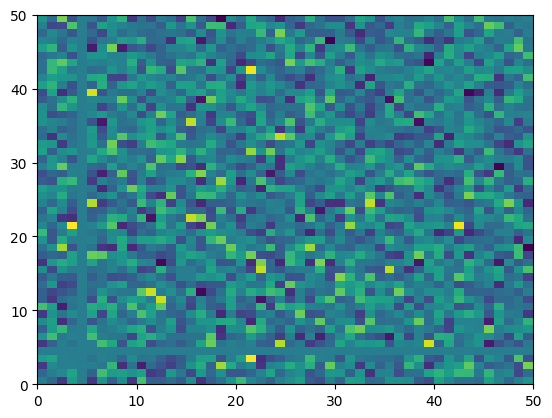

In [18]:
plt.pcolormesh((T[4, 0:50, 0:50]))